In [1]:
# ==========================================
# VAR DATA PREP: City / County / School
# ==========================================

import pandas as pd
import numpy as np

# ---------- 1. Load data ----------
city   = pd.read_csv('city_bond_index.csv')
county = pd.read_csv('county_bond_index.csv')
school = pd.read_csv('school_bond_index.csv')
vix    = pd.read_csv('muni_vix_data.csv')
liq    = pd.read_csv('muni_liquidity.csv')

# ---------- 2. Parse dates ----------
city['date']   = pd.to_datetime(city['date'],   format='%d-%m-%Y')
county['date'] = pd.to_datetime(county['date'], format='%Y-%m-%d')
school['date'] = pd.to_datetime(school['date'], format='%Y-%m-%d')
vix['date']    = pd.to_datetime(vix['date'],    format='%Y-%m-%d')
liq['date']    = pd.to_datetime(liq['date'],    format='%Y-%m-%d')

city   = city.sort_values('date')
county = county.sort_values('date')
school = school.sort_values('date')
vix    = vix.sort_values('date')
liq    = liq.sort_values('date')

# ---------- 3. Compute log returns for aggregate indices ----------
# These are the series All City / All County / All School
city['ret']   = 100 * np.log(city['All City']   / city['All City'].shift(1))
county['ret'] = 100 * np.log(county['All County'] / county['All County'].shift(1))
school['ret'] = 100 * np.log(school['All School'] / school['All School'].shift(1))

# ---------- 4. Weekly muni VIX ----------
vix_weekly = (
    vix.set_index('date')
       .resample('W-WED')['Weighted Average']
       .mean()
       .to_frame('muni_vix')
)

vix_weekly['muni_vix'] = vix_weekly['muni_vix'].ffill()
vix_weekly['d_muni_vix'] = vix_weekly['muni_vix'].diff()

# ---------- 5. Weekly liquidity by geo level ----------
liq_weekly = (
    liq.groupby('geo_level')
       .resample('W-WED', on='date')
       .agg({'rolling_sum': 'mean'})
       .reset_index()
       .rename(columns={'rolling_sum': 'liq_index', 'date': 'week'})
)

liq_weekly = liq_weekly.sort_values(['geo_level', 'week'])
liq_weekly['d_liq_index'] = liq_weekly.groupby('geo_level')['liq_index'].diff()
liq_weekly['d_liq_scaled'] = liq_weekly['d_liq_index'] / 1e8  # rescale for numerics

# mapping between our index types and liquidity geo_levels
geo_map = {'City': 'City', 'County': 'County', 'School': 'School District'}

# ---------- 6. Helper: build VAR dataframe for a given level ----------
def build_var_df(wide_df, level_name):
    """
    wide_df: city/county/school wide dataframe (with 'date' and 'ret')
    level_name: 'City', 'County', or 'School'
    Returns a dataframe with index 'date' and columns:
        ['d_muni_vix', 'd_liq_scaled', 'ret']
    ordered so orthogonalized IRFs treat:
        1st shock = volatility, 2nd = liquidity, 3rd = returns
    """
    df = wide_df[['date', 'ret']].copy()
    df = df.merge(
        vix_weekly.reset_index().rename(columns={'date': 'week'}),
        left_on='date', right_on='week', how='left'
    )
    df = df.merge(
        liq_weekly[liq_weekly['geo_level'] == geo_map[level_name]][['week', 'd_liq_scaled']],
        on='week', how='left'
    )
    # keep only rows where all three series are present
    df = df.dropna(subset=['ret', 'd_muni_vix', 'd_liq_scaled']).copy()
    df = df.set_index('date')

    # order columns for VAR identification: [vol, liq, returns]
    df = df[['d_muni_vix', 'd_liq_scaled', 'ret']]
    return df

# ---------- 7. Build VAR datasets ----------
var_city   = build_var_df(city,   'City')
var_county = build_var_df(county, 'County')
var_school = build_var_df(school, 'School')

print("VAR City shape:",   var_city.shape)
print("VAR County shape:", var_county.shape)
print("VAR School shape:", var_school.shape)

# Quick peek
var_city.head()


VAR City shape: (97, 3)
VAR County shape: (97, 3)
VAR School shape: (97, 3)


,d_muni_vix,d_liq_scaled,ret
date,,,
2019-01-02,-0.009313,-2.674628,2.190052
2020-01-08,-0.009422,0.292422,2.438433
2020-01-15,-0.002846,3.896660,1.405737
2020-01-22,0.002818,1.664626,0.848646
2020-01-29,-0.005291,-0.655428,0.068394



 VAR for All City

Lag order selection:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -2.593      -2.511     0.07481      -2.560
1      -3.389      -3.062     0.03374      -3.257
2      -3.806      -3.234     0.02227      -3.575
3      -4.081      -3.264     0.01693      -3.751
4     -4.401*     -3.339*    0.01233*     -3.973*
-------------------------------------------------

Chosen lag (AIC): 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Dec, 2025
Time:                     00:30:47
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.33933
Nobs:                     93.0000    HQIC:                  -3.97256
Log likelihood:          -152.219    FPE:                  0.0123283
AIC:                     -4.40138    

C:\Users\chait\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

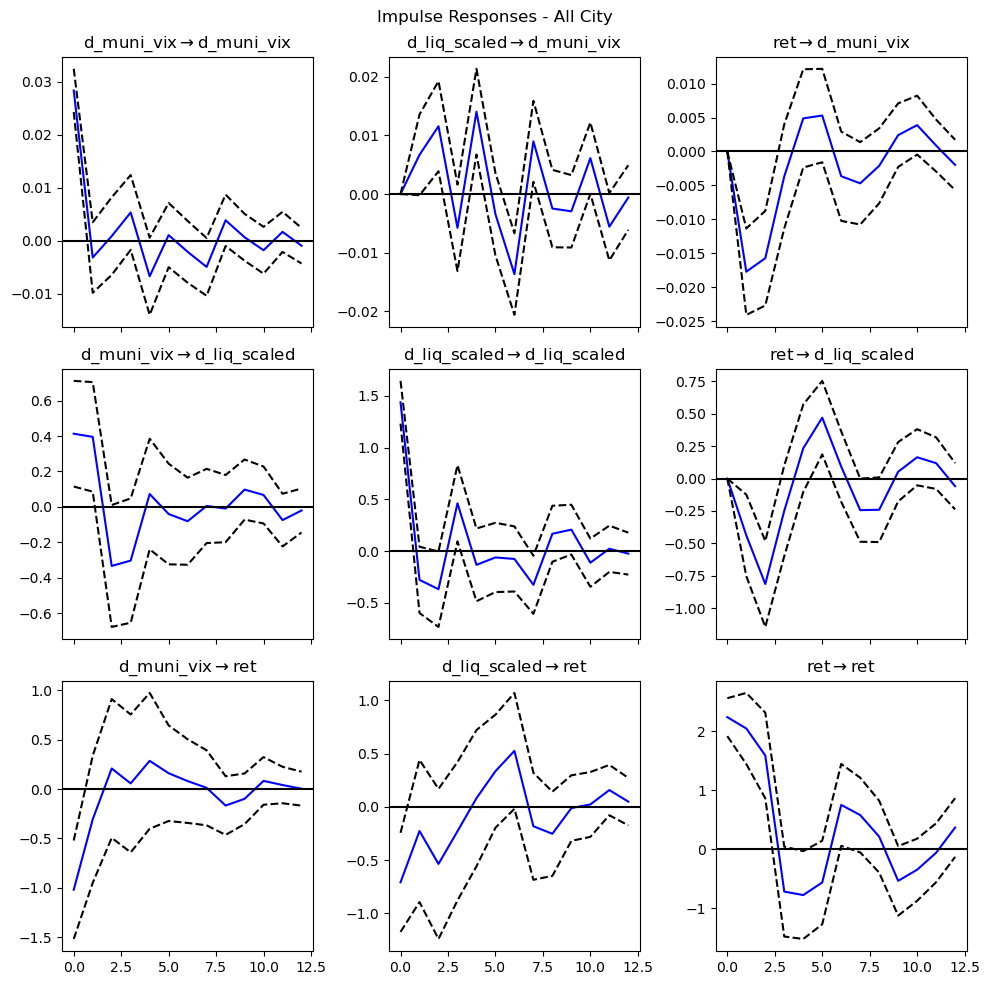

<Figure size 640x480 with 0 Axes>

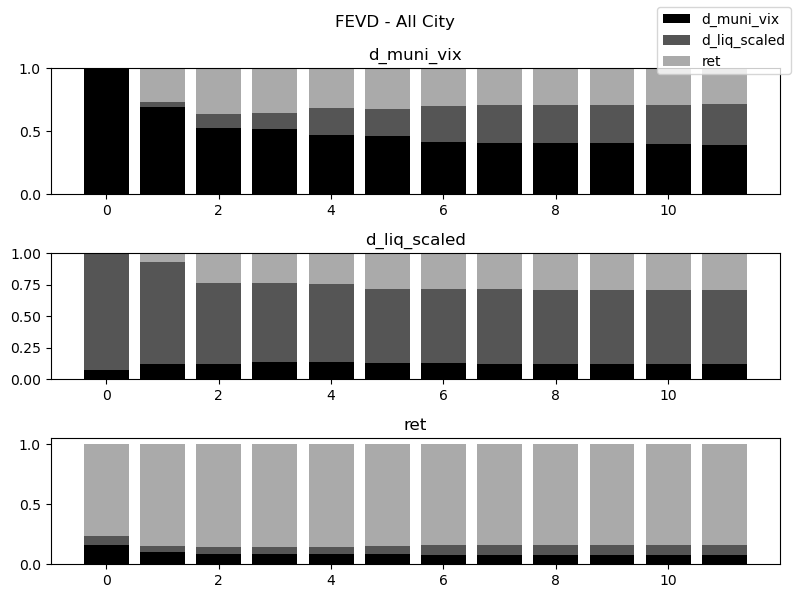


 VAR for All County

Lag order selection:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -5.340      -5.259    0.004794      -5.307
1      -6.144      -5.817    0.002147      -6.012
2      -6.568     -5.996*    0.001406      -6.337
3      -6.651      -5.834    0.001296      -6.321
4     -6.789*      -5.727   0.001132*     -6.361*
-------------------------------------------------

Chosen lag (AIC): 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Dec, 2025
Time:                     00:30:49
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -5.72733
Nobs:                     93.0000    HQIC:                  -6.36056
Log likelihood:          -41.1772    FPE:                 0.00113189
AIC:                     -6.78939  

C:\Users\chait\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

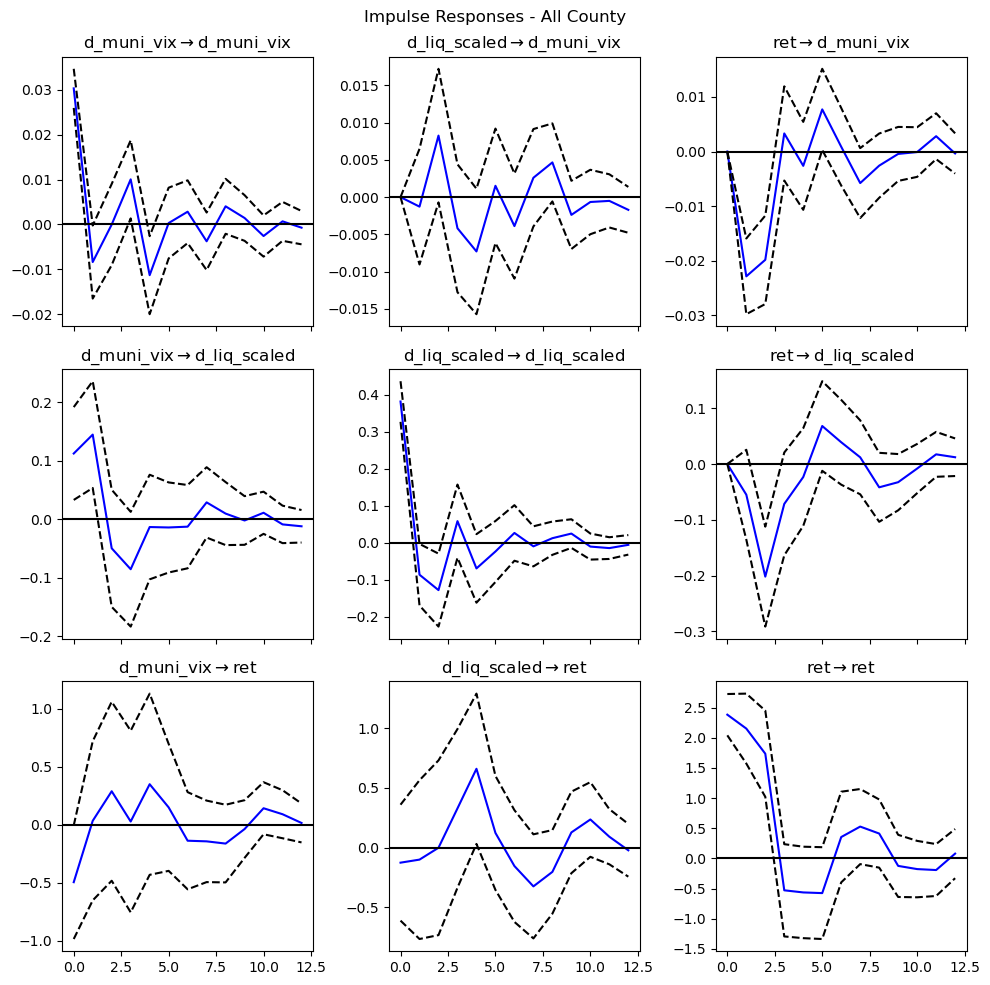

<Figure size 640x480 with 0 Axes>

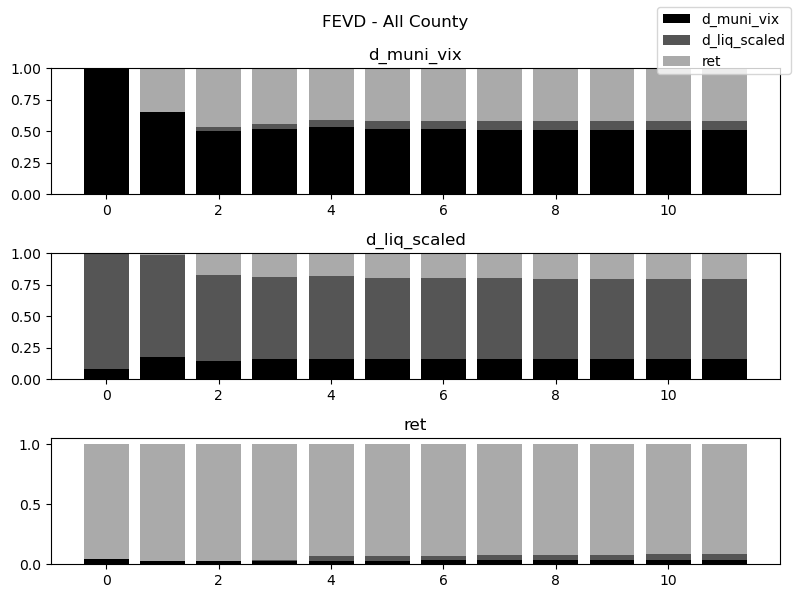


 VAR for All School

Lag order selection:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -4.332      -4.251     0.01314      -4.299
1      -5.163      -4.836    0.005725      -5.031
2      -5.682     -5.111*    0.003408      -5.452
3      -5.870      -5.053    0.002830     -5.540*
4     -5.904*      -4.842   0.002744*      -5.475
-------------------------------------------------

Chosen lag (AIC): 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Dec, 2025
Time:                     00:30:50
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -4.84181
Nobs:                     93.0000    HQIC:                  -5.47504
Log likelihood:          -82.3542    FPE:                 0.00274401
AIC:                     -5.90386  

C:\Users\chait\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

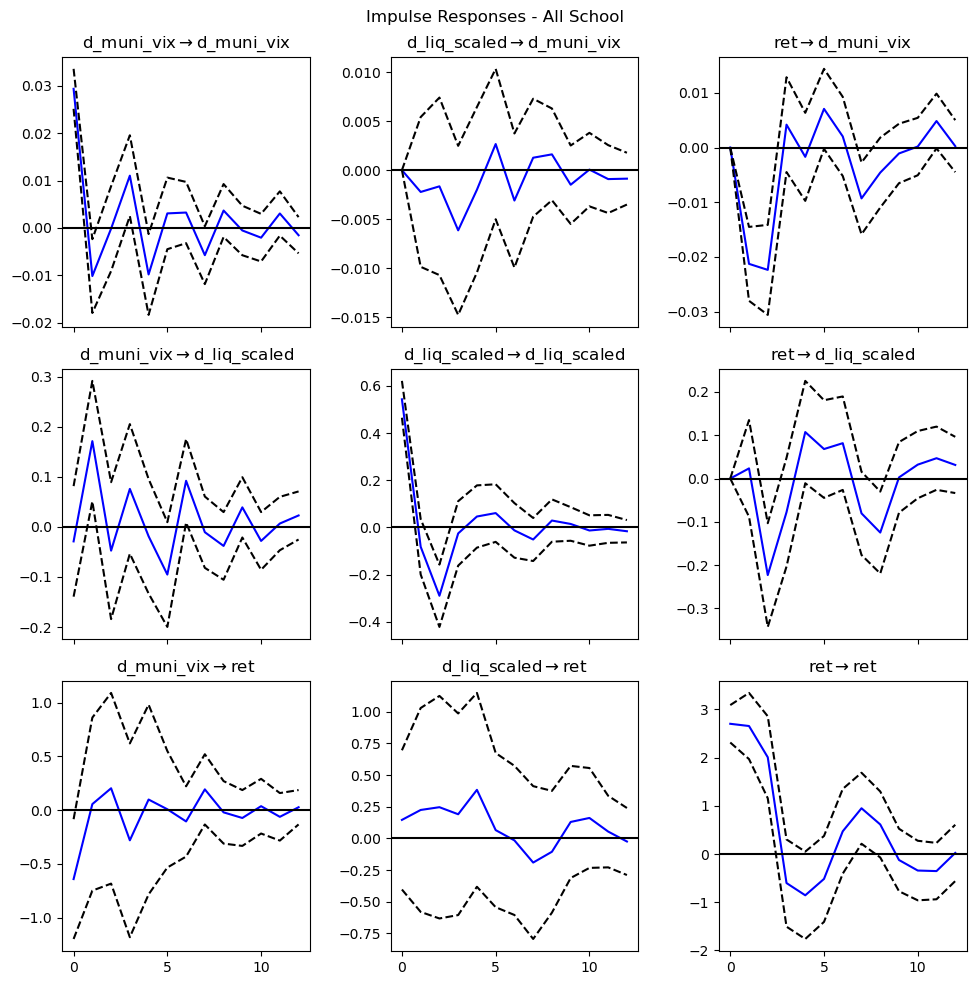

<Figure size 640x480 with 0 Axes>

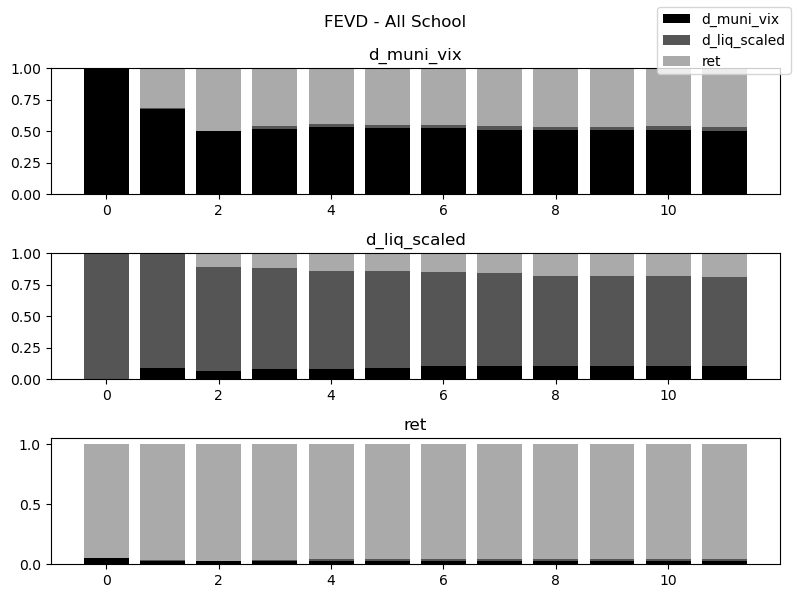

In [2]:
# ==========================================
# VAR ESTIMATION + IRFs + FEVD
# ==========================================

import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

def estimate_var_and_irf(df, name, maxlags=4, irf_horizon=12):
    """
    df: dataframe with columns ['d_muni_vix','d_liq_scaled','ret']
    name: label for printing and plot titles
    maxlags: maximum lag length to consider
    irf_horizon: horizon (in weeks) for IRFs and FEVD
    """
    print(f"\n==============================")
    print(f" VAR for {name}")
    print(f"==============================")

    # 1. Lag selection
    model = VAR(df)
    sel = model.select_order(maxlags=maxlags)
    print("\nLag order selection:")
    print(sel.summary())

    # Choose lag with minimum AIC (fallback to 2 if something weird)
    chosen_lag = sel.selected_orders.get('aic', 2)
    print(f"\nChosen lag (AIC): {chosen_lag}")

    # 2. Estimate VAR
    res = model.fit(chosen_lag)
    print(res.summary())

    # 3. Impulse Response Functions (orthogonalized via Cholesky)
    # Ordering: [d_muni_vix, d_liq_scaled, ret]
    irf = res.irf(irf_horizon)

    # Plot IRFs for return only (easier for paper)
    plt.figure()
    irf.plot(orth=True)
    plt.suptitle(f"Impulse Responses - {name}")
    plt.tight_layout()
    plt.show()

    # 4. Forecast Error Variance Decomposition (FEVD) for returns
    fevd = res.fevd(irf_horizon)
    plt.figure()
    fevd.plot(figsize=(8, 6))
    plt.suptitle(f"FEVD - {name}")
    plt.tight_layout()
    plt.show()

    return res, irf, fevd


# ---------- Run VARs for each issuer type ----------

res_city, irf_city, fevd_city = estimate_var_and_irf(var_city,   "All City",   maxlags=4, irf_horizon=12)
res_county, irf_county, fevd_county = estimate_var_and_irf(var_county, "All County", maxlags=4, irf_horizon=12)
res_school, irf_school, fevd_school = estimate_var_and_irf(var_school, "All School", maxlags=4, irf_horizon=12)
